# Variation Autoencoder for MNIST

潜在空間を平均$\mu$，分散$1.0$の正規分布として，導出したバージョン

結果的に，平均の推定値の2条誤差を最小とする正則化を導入し，中間層に平均$0.0$，分散$\sigma^2$の正規ノイズを付加して学習するAutoencoderと等価になる．

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [13]:
# ハイパーパラメータ
batch_size = 128
latent_dim = 2  # 中間層の次元 (>= 2)
epochs = 50
learning_rate = 1e-3
beta = 1.0  # KLダイバージェンスの重み
sigma = 0.1  # ノイズの標準偏差

# MNISTデータセットの読み込みとデータローダーの作成
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [14]:
# VAEモデルの定義
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
#        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        return mu

    def reparameterize(self, mu):
        eps = sigma * torch.randn_like(mu)  # $\sigma^2=1.0$
        z = mu + eps
#        z = mu
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu = self.encode(x)
        z = self.reparameterize(mu)
        x_recon = self.decode(z)
        return x_recon, mu



Epoch 1, Loss: 47.1483
Epoch 2, Loss: 37.5651
Epoch 3, Loss: 35.8078
Epoch 4, Loss: 34.9382
Epoch 5, Loss: 34.4086
Epoch 6, Loss: 34.0557
Epoch 7, Loss: 33.7509
Epoch 8, Loss: 33.4846
Epoch 9, Loss: 33.2843
Epoch 10, Loss: 33.0958
Epoch 11, Loss: 32.9132
Epoch 12, Loss: 32.7472
Epoch 13, Loss: 32.6360
Epoch 14, Loss: 32.4935
Epoch 15, Loss: 32.3744
Epoch 16, Loss: 32.2992
Epoch 17, Loss: 32.1902
Epoch 18, Loss: 32.1097
Epoch 19, Loss: 32.0444
Epoch 20, Loss: 31.9649
Epoch 21, Loss: 31.8788
Epoch 22, Loss: 31.8120
Epoch 23, Loss: 31.8033
Epoch 24, Loss: 31.7397
Epoch 25, Loss: 31.6555
Epoch 26, Loss: 31.5966
Epoch 27, Loss: 31.5755
Epoch 28, Loss: 31.5319
Epoch 29, Loss: 31.4743
Epoch 30, Loss: 31.4342
Epoch 31, Loss: 31.3734
Epoch 32, Loss: 31.3259
Epoch 33, Loss: 31.2854
Epoch 34, Loss: 31.2760
Epoch 35, Loss: 31.2124
Epoch 36, Loss: 31.1899
Epoch 37, Loss: 31.1686
Epoch 38, Loss: 31.1398
Epoch 39, Loss: 31.0954
Epoch 40, Loss: 31.0759
Epoch 41, Loss: 31.0492
Epoch 42, Loss: 31.0116
E

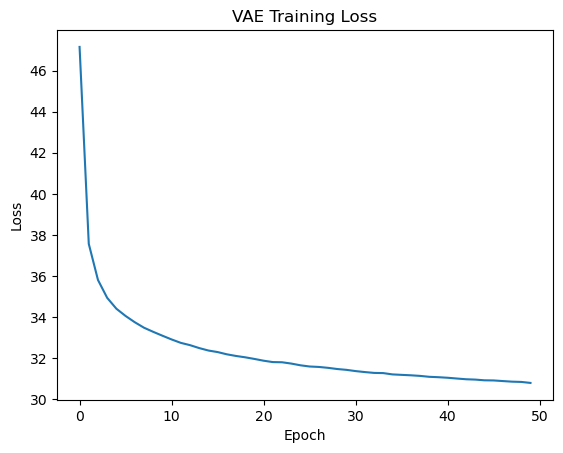

In [15]:
# モデル、損失関数、最適化手法の定義
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu):
#    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    MSE = nn.functional.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
#    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = -0.5 * torch.sum(1 - mu.pow(2))
    return MSE + beta*KLD

# 学習ループ
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu = model(data)
        loss = loss_function(recon_batch, data, mu)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}')

# 学習曲線のプロット
plt.plot(train_losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [16]:
# MSE lossの計算
def calculate_mse_loss(model, data_loader):
    model.eval()
    mse_loss = 0
    with torch.no_grad():
        for data, _ in data_loader:
            recon_batch, _ = model(data)
            mse_loss += nn.functional.mse_loss(recon_batch.view(-1, 784), data.view(-1, 784), reduction='sum').item()
    return mse_loss / len(data_loader.dataset)
mse_loss = calculate_mse_loss(model, train_loader)
print(f'MSE Loss: {mse_loss:.4f}')


MSE Loss: 30.3541


z_list shape: (60000, 2)


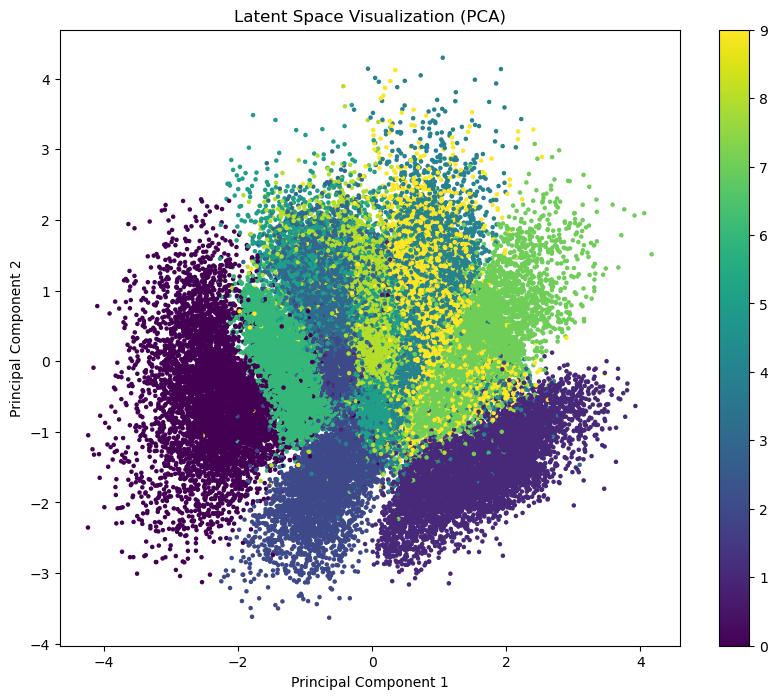

In [17]:
# 中間層の出力の可視化 (PCA適用)
model.eval()
z_list = []
labels_list = []
with torch.no_grad():
    for data, labels in train_loader:
        mu = model.encode(data)
        z = model.reparameterize(mu)
        z_list.extend(z.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
z_list = np.array(z_list)
labels_list = np.array(labels_list)

print(f"z_list shape: {z_list.shape}")

# PCAを使用して次元削減
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_list)

plt.figure(figsize=(10, 8))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels_list, cmap='viridis', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



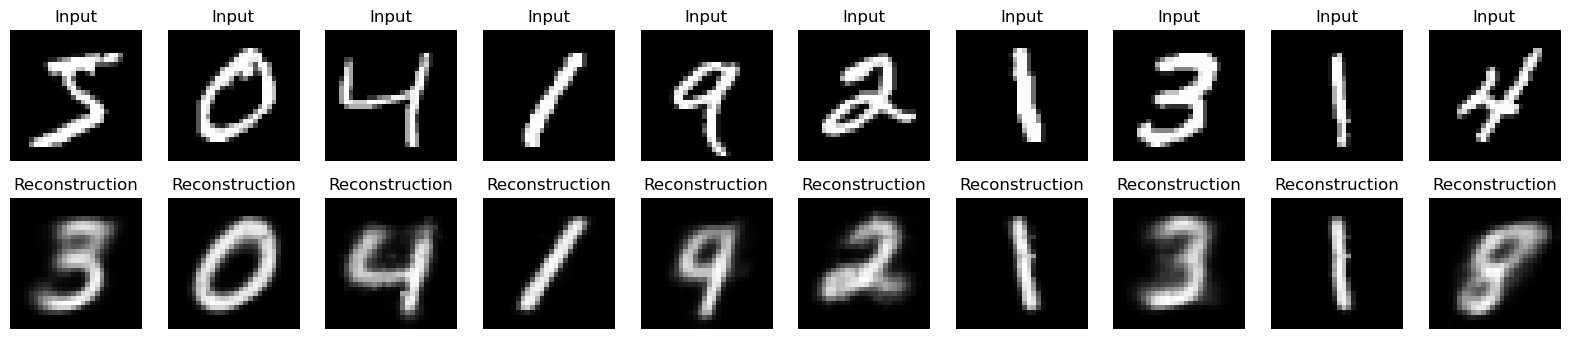

In [18]:
# 入力画像と再構成画像の比較
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    with torch.no_grad():
        sample = train_dataset[i][0].unsqueeze(0)
        recon_sample, _ = model(sample)
    plt.subplot(2, n, i+1)
    plt.imshow(sample.squeeze().numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_sample.squeeze().numpy(), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
plt.show()